<a href="https://colab.research.google.com/github/PallaviVangari/DM_Hotel_Recommendation_Project/blob/main/Hotel_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First few rows of the dataset:
             date_time  site_name  posa_continent  user_location_country  \
0  2014-08-11 07:46:59          2               3                     66   
1  2014-08-11 08:22:12          2               3                     66   
2  2014-08-11 08:24:33          2               3                     66   
3  2014-08-09 18:05:16          2               3                     66   
4  2014-08-09 18:08:18          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348                3210                  2234.2641   
1                   348                3210                  2234.2641   
2                   348                3210                  2234.2641   
3                   442                2316                   913.1932   
4            

<ipython-input-2-795e396192e3>:68: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, fmt=".2f")


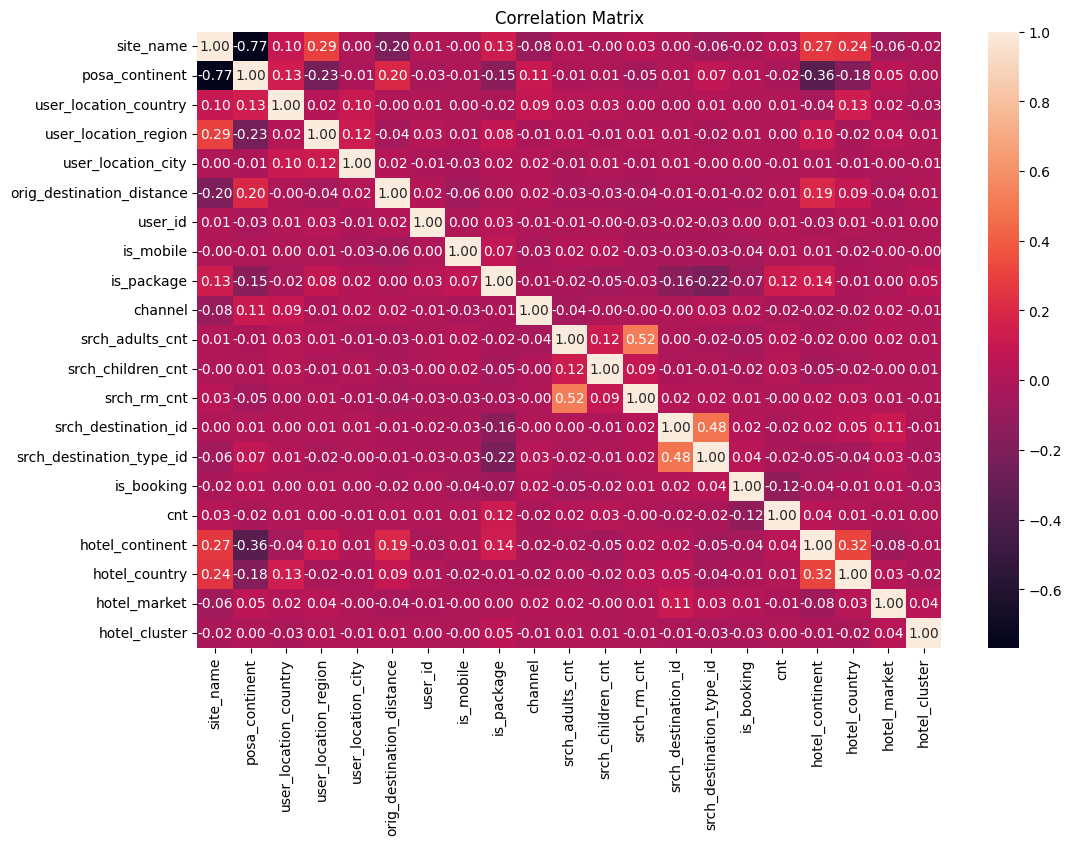

In [2]:
# Expedia Hotel Recommendation - Exploratory Data Analysis for Large Dataset

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')

# Load a subset of the data
train_file_path = '/content/drive/My Drive/expedia-hotel-recommendations/train.csv'
train = pd.read_csv(train_file_path, nrows=100000)  # Adjust nrows as per memory capacity

# Select features and target for the EDA
features = ['user_location_city', 'orig_destination_distance', 'srch_destination_id', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']
target = 'hotel_cluster'

# Data preprocessing for EDA
train.fillna(-1, inplace=True)

# Encoding categorical features
city_encoder = LabelEncoder()
train['user_location_city'] = city_encoder.fit_transform(train['user_location_city'])

destination_encoder = LabelEncoder()
train['srch_destination_id'] = destination_encoder.fit_transform(train['srch_destination_id'])

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(train.head())

# Basic information about the dataset
print("\\nBasic Information:")
print(train.info())

# Summary statistics for numerical features
print("\\nSummary Statistics for Numerical Features:")
print(train.describe())

# Summary statistics for categorical features
print("\\nSummary Statistics for Categorical Features:")
print(train.describe(include='object'))

# Visualization of data distributions
# Histograms for numerical features
numerical_features = train.select_dtypes(include=['float64', 'int64']).columns
# for feature in numerical_features:
#     plt.figure(figsize=(10, 4))
#     sns.histplot(train[feature], kde=True)
#     plt.title(f'Histogram for {feature}')
#     plt.show()

# Count plots for categorical features
categorical_features = train.select_dtypes(include=['object']).columns
# for feature in categorical_features:
#     plt.figure(figsize=(10, 4))
#     sns.countplot(x=feature, data=train)
#     plt.title(f'Count Plot for {feature}')
#     plt.xticks(rotation=45)
#     plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [3]:
# Data Preprocessing for Expedia Hotel Recommendation

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Selecting features for the model
# Based on the correlation matrix and domain understanding, we select a mix of features
# that are not too heavily correlated with each other but may have an impact on the hotel cluster
features = ['user_location_city', 'orig_destination_distance', 'srch_destination_id', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'hotel_country']
target = 'hotel_cluster'

# Preprocessing Steps:
# 1. Handle missing values
# 2. Encode categorical variables
# 3. Feature scaling for numerical variables

# Separating the features and the target variable
X = train[features]
y = train[target]

# Identifying numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Creating transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputes missing values using the mean
    ('scaler', StandardScaler())                 # Scales numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputes missing values using the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Applies one-hot encoding to categorical features
])

# Combining transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Applying the preprocessing pipeline to the feature data
X_preprocessed = preprocessor.fit_transform(X)

# Splitting the preprocessed data into training and testing sets
# It is a good practice to split the data before any training to avoid data leakage
X_train_preprocessed, X_test_preprocessed, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# The preprocessed data is now ready for model training
# The next step will be to choose a model and proceed with training


In [4]:
# Ensemble Model Training for Hotel Recommendation System

# Importing necessary libraries
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# 1. Define the Random Forest Classifier
# Random Forest is an ensemble learning method itself, constructing a multitude of decision trees.
# It's known for its robustness and effectiveness in handling tabular data.
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    random_state=42   # Ensuring reproducibility
)

# 2. Define the XGBoost Classifier
# XGBoost is a gradient boosting framework that uses boosting techniques to optimize models.
# It's powerful for handling a variety of data types and often delivers top performance in competitions.
xgb_model = xgb.XGBClassifier(
    n_estimators=100,    # Number of gradient boosted trees
    learning_rate=0.1,   # Step size shrinkage used in update to prevent overfitting
    max_depth=6,         # Maximum depth of a tree
    subsample=0.8,       # Subsample ratio of the training instances (prevents overfitting)
    colsample_bytree=0.8,# Subsample ratio of columns when constructing each tree
    random_state=42,     # Random number seed
    use_label_encoder=False, # Disable the use of label encoder
    eval_metric='mlogloss'   # Multiclass log loss for evaluation
)

# 3. Combine Models into a Voting Ensemble
# We use 'soft' voting which considers the predicted probabilities to determine the final class.
# This is usually more flexible and accounts for uncertainty in the predictions.
ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    voting='soft'  # Soft voting
)

# 4. Train the Ensemble Model
# The ensemble model will train each component model on the training data.
ensemble_model.fit(X_train_preprocessed, y_train)

# 5. Predict on the Test Set
# The ensemble model uses the voting mechanism to make predictions on the test set.
y_pred_ensemble = ensemble_model.predict(X_test_preprocessed)

# 6. Evaluate the Ensemble Model's Performance
# We use accuracy and classification report as our metrics to evaluate the model performance.
print("Accuracy on test set:", accuracy_score(y_test, y_pred_ensemble))
print("\nClassification Report for Ensemble Model:\n", classification_report(y_test, y_pred_ensemble))

# Note: To further enhance the model performance, consider performing hyperparameter tuning
# on the individual models (Random Forest and XGBoost) and experimenting with different voting strategies.


Accuracy on test set: 0.37485

Classification Report for Ensemble Model:
               precision    recall  f1-score   support

           0       0.34      0.42      0.38       174
           1       0.54      0.66      0.60       205
           2       0.40      0.44      0.42       241
           3       0.33      0.30      0.32       105
           4       0.41      0.39      0.40       180
           5       0.29      0.26      0.27       320
           6       0.40      0.35      0.37       230
           7       0.37      0.32      0.34       139
           8       0.46      0.49      0.47       216
           9       0.36      0.38      0.37       256
          10       0.38      0.36      0.37       226
          11       0.29      0.34      0.32       164
          12       0.30      0.34      0.32       136
          13       0.48      0.42      0.45       181
          14       0.21      0.17      0.19       105
          15       0.39      0.35      0.37       159
       

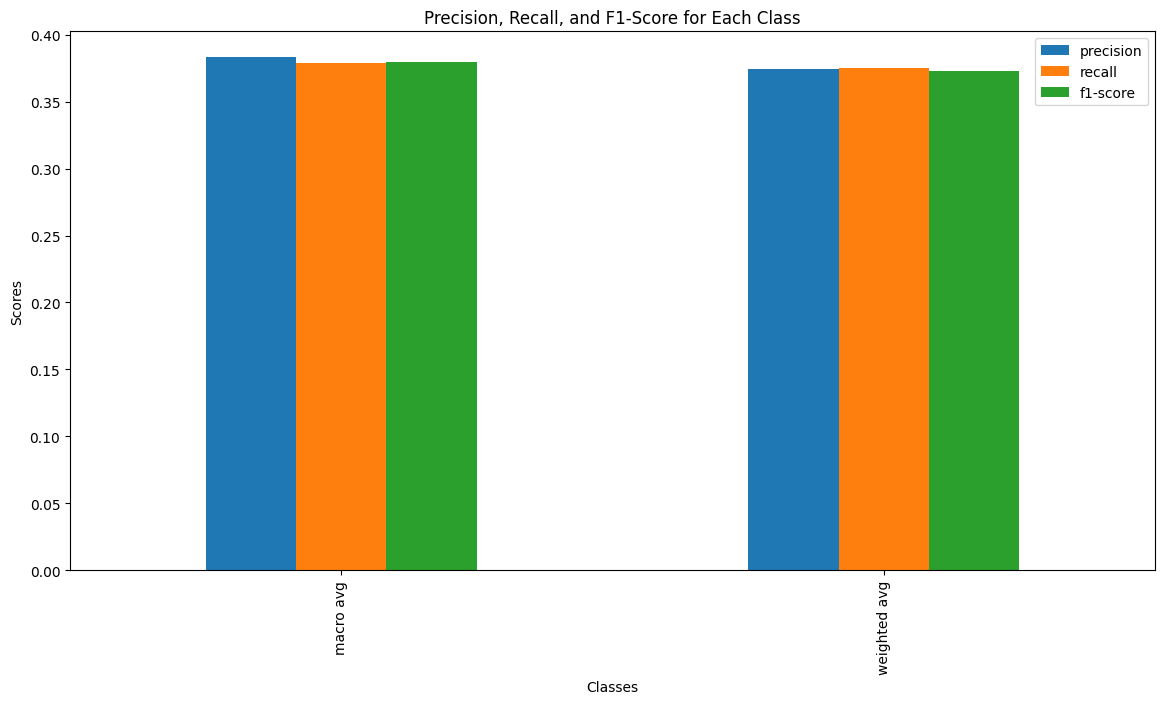

In [5]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate a classification report
report = classification_report(y_test, y_pred_ensemble, output_dict=True)

# Convert the report to a DataFrame for easy plotting
report_df = pd.DataFrame(report).transpose()

# Plot the precision, recall, and F1-score for each class
report_df[-2:].drop(['support'], axis=1).plot(kind='bar', figsize=(14,7))
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.show()


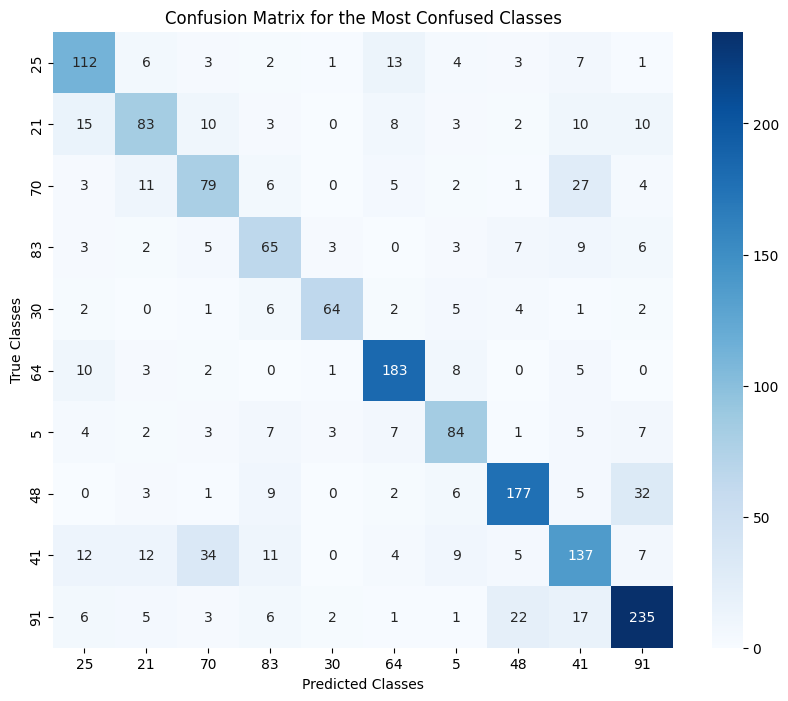

In [6]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_ensemble are already defined from previous model predictions
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_ensemble)

# Select a subset of classes, for example, the top 10 most confused classes
most_confused = np.argsort(cm.sum(axis=1) - np.diag(cm))[-10:]  # This finds the classes with the most off-diagonal entries

# Create a smaller confusion matrix for the most confused classes
small_cm = cm[np.ix_(most_confused, most_confused)]

# Plot the smaller confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(small_cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=most_confused, yticklabels=most_confused)
plt.title('Confusion Matrix for the Most Confused Classes')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


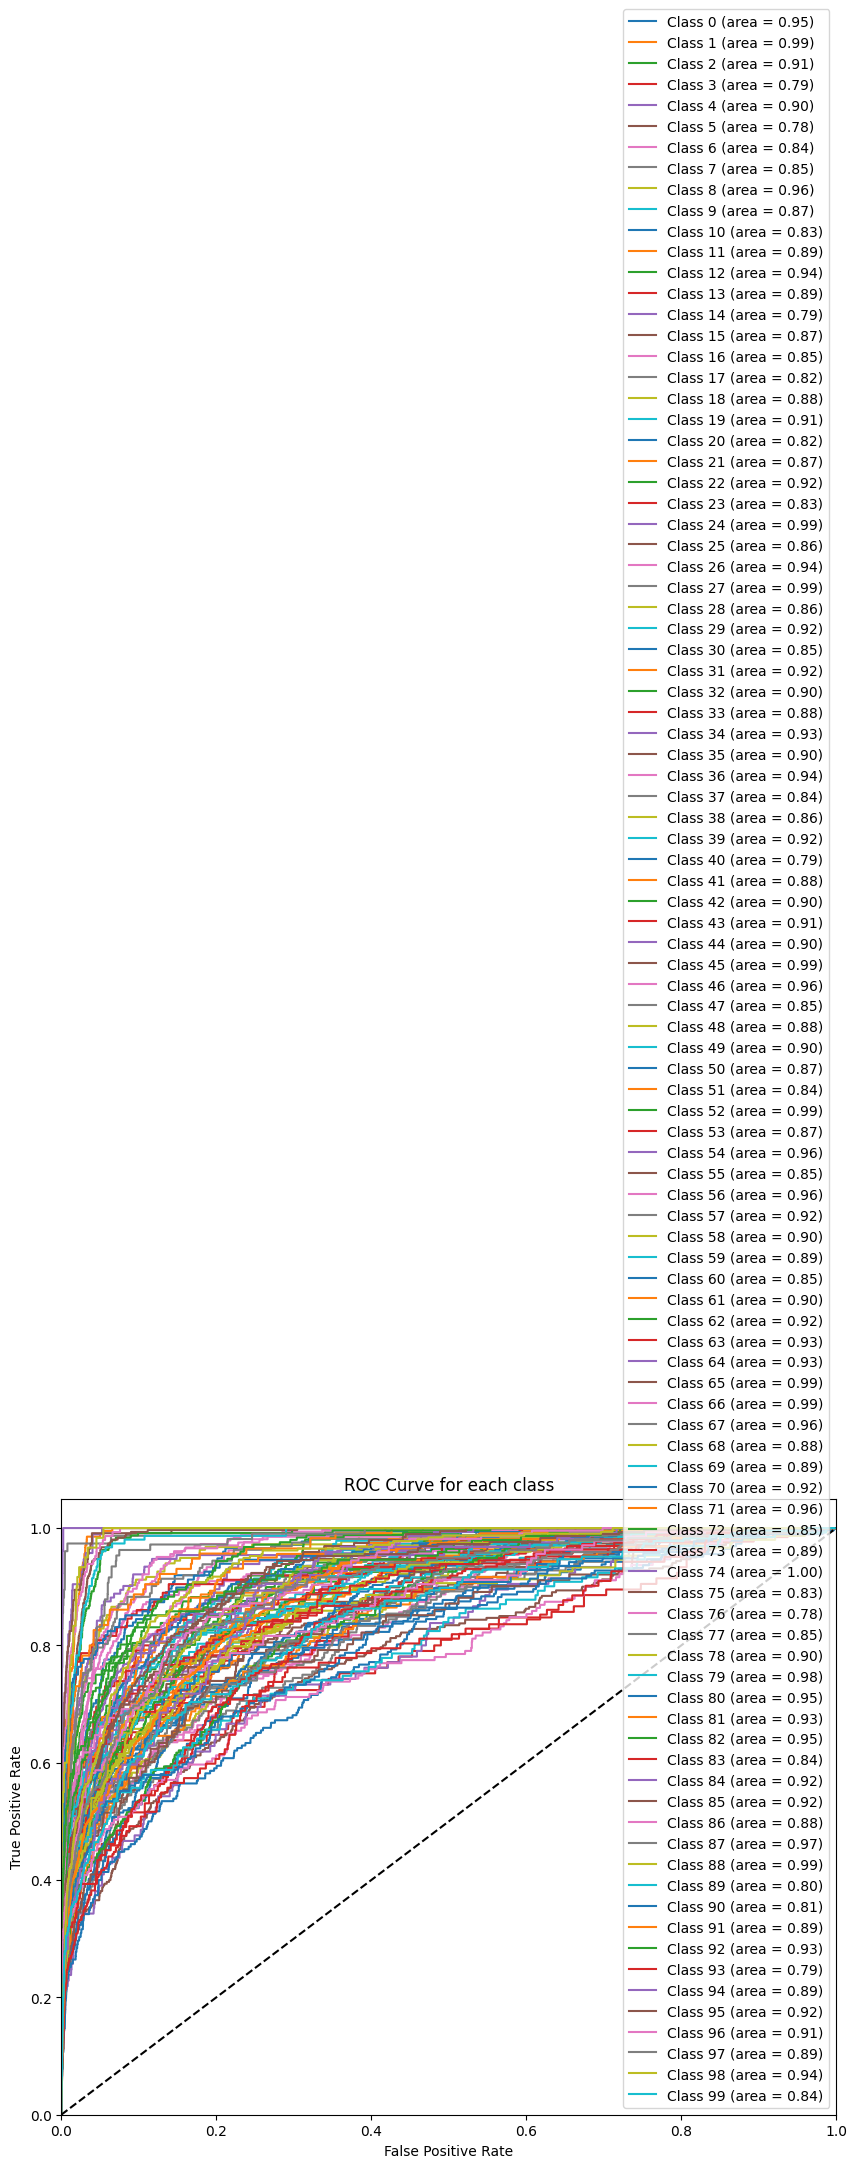

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
y_pred_prob = ensemble_model.predict_proba(X_test_preprocessed)

# Compute ROC-AUC for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Define a random grid of hyperparameters to search, with a simpler and smaller range
param_dist = {
    'rf__n_estimators': sp_randint(50, 100),  # Smaller range of trees
    'rf__max_depth': [None, 5, 10],           # Simplified depth options
    'xgb__n_estimators': sp_randint(50, 100), # Smaller range for XGBoost as well
    'xgb__learning_rate': [0.01, 0.05, 0.1]   # Fewer options for learning rate
}

# Create a RandomizedSearchCV object with less iterations and folds
random_search = RandomizedSearchCV(
    estimator=ensemble_model,
    param_distributions=param_dist,
    n_iter=5,               # Fewer iterations
    scoring='accuracy',
    cv=2,                   # Fewer folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Use a subset of your data for the hyperparameter tuning to save RAM
subset_size = 10000  # Adjust this to fit into your RAM
X_train_subset = X_train_preprocessed[:subset_size]
y_train_subset = y_train[:subset_size]

# Perform the random search and find the best parameters
random_search.fit(X_train_subset, y_train_subset)

# Print out the best parameters and the best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'rf__max_depth': 10, 'rf__n_estimators': 78, 'xgb__learning_rate': 0.1, 'xgb__n_estimators': 92}
Best score: 0.11960000000000001


In [9]:
# Model Tuning with Best Hyperparameters

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# Apply the best hyperparameters from the grid search to the individual models
rf_tuned = RandomForestClassifier(
    n_estimators=78,  # Best number of trees
    max_depth=10,     # Best maximum depth of trees
    random_state=42   # For reproducibility
)

xgb_tuned = xgb.XGBClassifier(
    n_estimators=92,    # Best number of gradient boosted trees
    learning_rate=0.1,  # Best learning rate
    random_state=42,    # For reproducibility
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Create the voting classifier ensemble with the tuned models
ensemble_tuned = VotingClassifier(
    estimators=[
        ('rf', rf_tuned),
        ('xgb', xgb_tuned)
    ],
    voting='soft'  # Soft voting to use probabilities for prediction
)

# Fit the ensemble model to the entire training data
ensemble_tuned.fit(X_train_preprocessed, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=78,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=N...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=92, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [10]:
# Model Serialization

import joblib

# Save the trained model to disk for later use
joblib.dump(ensemble_tuned, 'tuned_ensemble_model.joblib')

# Note: To load the model from disk, you would use the following command:
# loaded_model = joblib.load('tuned_ensemble_model.joblib')


['tuned_ensemble_model.joblib']